In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import datetime
import time

## Downloading data directly from the official source

#### So that we don't download them too much (be nice weith servers, think of the Planet ;) ) 

In [2]:
## run DOWNLOAD_timeSeries-publicHealth.ipynb  (once per day if you want, not more)

## Extending the date range (for later merging the dataframes)

#### (TODO) + Linear interploation of missing dates

#### (TODO) + filling in missing dates with coolumns full of missing values (or extrapolated values)

In [3]:
output_filename1 = "../input/covid19-granular-demographics-and-times-series/population_normalizing_divBySubPop.csv"
output_filename2 = "../input/covid19-granular-demographics-and-times-series/time_series_covid_incidence_divBySubPop.csv"

In [4]:
## constantes ##
initialDate = datetime.datetime(year=2020, month=2, day=23).date() # 
today = (datetime.datetime.today()).date() ## keep only the day, not minutes, etc

In [5]:
## assumes dates to be present in a COLUMN ##
def complete_dates(df1,initialDate, today):
    NignoredColumns = 2
   
    df = df1.copy() 
    
    ## convert columns names into standard format (if not already the case)
    dates = pd.to_datetime(df1.date.unique()).date
    ## look for days of first and last data available (ssuming column=dates are sorted)
    day_1 = dates[0]
    data_at_day_1 = df[df.date==str(day_1)]
    day_last = dates[-1]
    data_at_day_last = df[df.date==str(day_last)] 
    
    alreadyPresentDates = pd.to_datetime(df.date.unique()).date
    day_count = (today - initialDate).days
    for n in range(day_count):
        day = initialDate + datetime.timedelta(n)
        if day not in alreadyPresentDates :
#             template = data_at_day_1.copy() 
#             template.iloc[:,NignoredColumns:] = np.nan 
#             template.date = day.strftime('%Y-%m-%d')
#             df = df.append(template.copy())
            if day < day_1 :
                template = data_at_day_1.copy()
                template.iloc[:,NignoredColumns:] = data_at_day_1.iloc[:,NignoredColumns:]
                template.date = day.strftime('%Y-%m-%d')
                df = df.append(template.copy())
            elif day > day_last:
                template = data_at_day_last.copy() 
                template.iloc[:,NignoredColumns:] = data_at_day_last.iloc[:,NignoredColumns:]
                template.date = day.strftime('%Y-%m-%d')
                df = df.append(template.copy())
            else:              
                template = data_at_day_1.copy() # df[df.date==str(previousDay)].copy()
                ## search for previous and next dates with data.
                ## then interploate linealry between these dates                
                previousDay = day - datetime.timedelta(1)
                nextDayWithData = day
                counter = 1.0
                while nextDayWithData not in alreadyPresentDates:
                    nextDayWithData += datetime.timedelta(1)
                    counter += 1 
                nextData = (df[df.date==str(nextDayWithData)].iloc[:,NignoredColumns:]).values.astype(float)
                previousData = (df[df.date==str(previousDay)].iloc[:,NignoredColumns:]).values.astype(float)
                template.iloc[:,NignoredColumns:] = previousData + (nextData - previousData)/counter
                template.date = day.strftime('%Y-%m-%d')
#                 print("\ncounter", counter, "\ntemplate", template, "\nnextData", nextData, "\npreviousData", previousData)
                df = df.append(template.copy())           
                ## refresh : 
                alreadyPresentDates = pd.to_datetime(df.date.unique()).date                             
                    
    df = df.sort_values(by=["date", "code"])
    return df

## Adapt input data to more practical format 

### The "donnees-hospitalieres-nouveaux-covid19-YYYY-MM-DD-19h00.csv" is already adapted to our format

This data relates to the daily incoming flux of people (in hospital, in ICU, in returned home, and in death)

In [6]:
# input_filename0 = "temp/donnees-hospitalieres-classe-age-covid19-2020-05-16-19h00.csv" ## only regional scale
input_filename1 = "temp/donnees-hospitalieres-nouveaux-covid19-YYYY-MM-DD-19h00.csv"
df1 = pd.read_csv(input_filename1, delimiter=',')
df1 = df1.rename(columns={"dep":"code", "jour":"date"})
df1 = df1.drop(index = df1.index[ df1.code=='976' ]  )
df1 = complete_dates(df1,initialDate, today)
prefix = "Nbre_sex=all_agemin=0_agemax=150_"
df1 = df1.rename(columns={'incid_hosp': prefix+"newly_hospitalized" , 'incid_rea':prefix+"newly_ICU"\
                         ,'incid_dc'  : prefix+"new_deaths",          'incid_rad':prefix+"newly_discharged" })
df1

code        date  Nbre_sex=all_agemin=0_agemax=150_newly_hospitalized  \
0       01  2020-02-23                                                  1     
250     02  2020-02-23                                                 38     
500     03  2020-02-23                                                  2     
750     04  2020-02-23                                                  1     
1000    05  2020-02-23                                                  4     
...    ...         ...                                                ...     
23999   95  2020-11-23                                                 26     
24249  971  2020-11-23                                                  1     
24499  972  2020-11-23                                                  2     
24749  973  2020-11-23                                                  7     
24999  974  2020-11-23                                                  1     

       Nbre_sex=all_agemin=0_agemax=150_newly_ICU  \
0                                               0   
250                                             8   
500                                             0   
750                                             0   
1000                                            0   
...                                           ...   
23999                                           3   
24249                                           1   
24499                                           0   
24749                                           1   
24999                                           1   

       Nbre_sex=all_agemin=0_agemax=150_new_deaths  \
0                                                0   
250                                             10   
500                                              0   
750                                              0   
1000                                             0   
...                                            ...   
23999                                           12   
24249                                            2   
24499                                            0   
24749                                            0   
24999                                            1   

       Nbre_sex=all_agemin=0_agemax=150_newly_discharged  
0                                                      0  
250                                                   15  
500                                                    6  
750                                                    1  
1000                                                   1  
...                                                  ...  
23999                                                 24  
24249                                                  3  
24499                                                  1  
24749                                                  2  
24999                                                  0  

[27500 rows x 6 columns]

### The "donnees-hospitalieres-covid19-YYYY-MM-DD-19h00.csv" have sex categories but no age

This data relates to the total number present in hospital or present in ICU, and cumulated number of death since beggining/ cumulated number of returned home since the beggining.

In [7]:
input_filename2= "temp/donnees-hospitalieres-covid19-YYYY-MM-DD-19h00.csv"
df2 = pd.read_csv(input_filename2, delimiter=',')
df2 = df2.rename(columns={"dep":"code", "jour":"date"})
df2 = df2.drop(index = df2.index[ df2.code=='976' ]  )
df2

code  sexe        date  hosp  rea   rad  dc
0       01     0  2020-03-18     2    0     1   0
1       01     1  2020-03-18     1    0     1   0
2       01     2  2020-03-18     1    0     0   0
3       02     0  2020-03-18    41   10    18  11
4       02     1  2020-03-18    19    4    11   6
...    ...   ...         ...   ...  ...   ...  ..
76045  973     1  2020-11-23     5    0   756  43
76046  973     2  2020-11-23     8    1  1093  23
76047  974     0  2020-11-23    87   15   593  44
76048  974     1  2020-11-23    47    8   295  20
76049  974     2  2020-11-23    40    7   298  24

[75300 rows x 7 columns]

### We compare this data (which is a snapshot of instant data), versus the previous one (snapshot at a given time)

Some information is 99.X% redundant, as we show on an example.

In [8]:
print(df2.columns)
TESTCODE = '75'  ## numbers are high in Paris (75)
X = df2[(df2.code==TESTCODE) & (df2.sexe==0)]

input_filename1 = "temp/donnees-hospitalieres-nouveaux-covid19-YYYY-MM-DD-19h00.csv"
df_temp = pd.read_csv(input_filename1, delimiter=',')
df_temp = df_temp.rename(columns={"dep":"code", "jour":"date"})
Xn = df_temp[df_temp.code==TESTCODE]

Index(['code', 'sexe', 'date', 'hosp', 'rea', 'rad', 'dc'], dtype='object')


Text(0.5, 1.0, 'cumulated number of covid-deaths (at hospital/ICU only)')

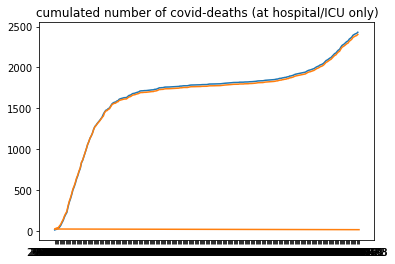

In [9]:
plt.plot(Xn.date, np.cumsum(Xn.incid_dc))
plt.plot(X.date, X.dc)
plt.title("cumulated number of covid-deaths (at hospital/ICU only)")

Text(0.5, 1.0, 'cumulated number of discharged (returned home)')

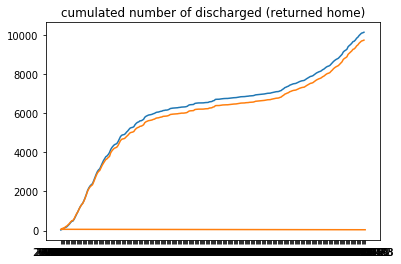

In [10]:
plt.plot(Xn.date, np.cumsum(Xn.incid_rad))
plt.plot(X.date, X.rad)
plt.title("cumulated number of discharged (returned home)")
##  (a recovery is never definitive)

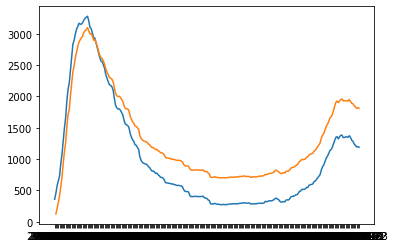

In [11]:
Xn_fluxNetHopital = Xn.incid_hosp - Xn.incid_dc - Xn.incid_rad
plt.plot(X.date, X.hosp)
plt.plot(Xn.date, np.cumsum(Xn_fluxNetHopital))

In [12]:
## silly because people die from everything - but all deaths passed through ICU
# fluxNetREA = Xn.incid_rea - Xn.incid_dc - Xn.incid_rad
# plt.plot(X.jour, X.rea)
# plt.plot(Xn.jour, np.cumsum(fluxNetREA))

### Conclusion : we can skip the deaths and discharged columns, but not the hosp or ICU ones.

In [13]:
df2 = pd.read_csv(input_filename2, delimiter=',')
df2 = df2.rename(columns={"dep":"code", "jour":"date"})
##
df2 = df2.loc[df2.sexe==0]
df2 = df2.drop(columns=['sexe', 'rad', 'dc'])
df2 = df2.rename(columns={"hosp":"Nbre_sex=all_agemin=0_agemax=150_beds_hosp_occupied","rea":"Nbre_sex=all_agemin=0_agemax=150_beds_ICU_occupied", })
df2 = df2.drop(index = df2.index[ df2.code=='976' ]  )
df2 = df2.drop(index = df2[df2.code.isna()].index )
df2 = complete_dates(df2,initialDate, today)

In [14]:
df2

code        date  Nbre_sex=all_agemin=0_agemax=150_beds_hosp_occupied  \
0       01  2020-02-23                                                  2     
3       02  2020-02-23                                                 41     
6       03  2020-02-23                                                  4     
9       04  2020-02-23                                                  3     
12      05  2020-02-23                                                  8     
...    ...         ...                                                ...     
76035   95  2020-11-23                                                526     
76038  971  2020-11-23                                                 96     
76041  972  2020-11-23                                                 56     
76044  973  2020-11-23                                                 13     
76047  974  2020-11-23                                                 87     

       Nbre_sex=all_agemin=0_agemax=150_beds_ICU_occupied  
0                                                      0   
3                                                     10   
6                                                      0   
9                                                      1   
12                                                     1   
...                                                  ...   
76035                                                 53   
76038                                                  7   
76041                                                 17   
76044                                                  1   
76047                                                 15   

[27500 rows x 4 columns]

### In "sursaud-covid19-quotidien-YYYY-MM-DD-19h00-departement.csv", we keep only the columns which have the most data

In [15]:
input_filename2= "temp/sursaud-covid19-quotidien-YYYY-MM-DD-19h00-departement.csv"
df3 = pd.read_csv(input_filename2 , delimiter=',')
df3 = df3.rename(columns={"dep":"code", 'date_de_passage':"date", "sursaud_cl_age_corona":"agerange"\
                        ,"nbre_pass_corona":"ICU_vis_covid" \
                        ,"nbre_pass_tot":   "ICU_vis_allCauses" \
                        ,"nbre_hospit_corona": "adm_covid"\
                 })
print(df3.notna().sum())  # code.unique().size

code                    165438
date                    165438
agerange                165438
ICU_vis_covid           163534
ICU_vis_allCauses       163534
adm_covid               163534
nbre_pass_corona_h       27291
nbre_pass_corona_f       27291
nbre_pass_tot_h          27291
nbre_pass_tot_f          27291
nbre_hospit_corona_h     27291
nbre_hospit_corona_f     27291
nbre_acte_corona         74927
nbre_acte_tot            74927
nbre_acte_corona_h       12543
nbre_acte_corona_f       12543
nbre_acte_tot_h          12543
nbre_acte_tot_f          12543
dtype: int64


/home/flandes/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
df3

code        date agerange  ICU_vis_covid  ICU_vis_allCauses  adm_covid  \
0         1  2020-02-24        0            0.0              357.0        0.0   
1         1  2020-02-24        A            0.0               73.0        0.0   
2         1  2020-02-24        B            0.0              155.0        0.0   
3         1  2020-02-24        C            0.0               61.0        0.0   
4         1  2020-02-24        D            0.0               28.0        0.0   
...     ...         ...      ...            ...                ...        ...   
165433  976  2020-11-22        A            0.0               48.0        0.0   
165434  976  2020-11-22        B            1.0               37.0        0.0   
165435  976  2020-11-22        C            0.0               12.0        0.0   
165436  976  2020-11-22        D            NaN                NaN        NaN   
165437  976  2020-11-22        E            NaN                NaN        NaN   

        nbre_pass_corona_h  nbre_pass_corona_f  nbre_pass_tot_h  \
0                      0.0                 0.0            202.0   
1                      NaN                 NaN              NaN   
2                      NaN                 NaN              NaN   
3                      NaN                 NaN              NaN   
4                      NaN                 NaN              NaN   
...                    ...                 ...              ...   
165433                 NaN                 NaN              NaN   
165434                 NaN                 NaN              NaN   
165435                 NaN                 NaN              NaN   
165436                 NaN                 NaN              NaN   
165437                 NaN                 NaN              NaN   

        nbre_pass_tot_f  nbre_hospit_corona_h  nbre_hospit_corona_f  \
0                 155.0                   0.0                   0.0   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3                   NaN                   NaN                   NaN   
4                   NaN                   NaN                   NaN   
...                 ...                   ...                   ...   
165433              NaN                   NaN                   NaN   
165434              NaN                   NaN                   NaN   
165435              NaN                   NaN                   NaN   
165436              NaN                   NaN                   NaN   
165437              NaN                   NaN                   NaN   

        nbre_acte_corona  nbre_acte_tot  nbre_acte_corona_h  \
0                    NaN            NaN                 NaN   
1                    NaN            NaN                 NaN   
2                    NaN            NaN                 NaN   
3                    NaN            NaN                 NaN   
4                    NaN            NaN                 NaN   
...                  ...            ...                 ...   
165433               NaN            NaN                 NaN   
165434               NaN            NaN                 NaN   
165435               NaN            NaN                 NaN   
165436               NaN            NaN                 NaN   
165437               NaN            NaN                 NaN   

        nbre_acte_corona_f  nbre_acte_tot_h  nbre_acte_tot_f  
0                      NaN              NaN              NaN  
1                      NaN              NaN              NaN  
2                      NaN              NaN              NaN  
3                      NaN              NaN              NaN  
4                      NaN              NaN              NaN  
...                    ...              ...              ...  
165433                 NaN              NaN              NaN  
165434                 NaN              NaN              NaN  
165435                 NaN              NaN         

In [17]:
## We keep columns with all values present, leave out columns with lots of missing values
df3 = df3[['code', 'date', 'agerange', 'ICU_vis_covid', 'ICU_vis_allCauses', 'adm_covid']]
df3 = df3.drop(index = df3.index[ df3.code=='976' ]  )
df3

code        date agerange  ICU_vis_covid  ICU_vis_allCauses  adm_covid
0         1  2020-02-24        0            0.0              357.0        0.0
1         1  2020-02-24        A            0.0               73.0        0.0
2         1  2020-02-24        B            0.0              155.0        0.0
3         1  2020-02-24        C            0.0               61.0        0.0
4         1  2020-02-24        D            0.0               28.0        0.0
...     ...         ...      ...            ...                ...        ...
165433  976  2020-11-22        A            0.0               48.0        0.0
165434  976  2020-11-22        B            1.0               37.0        0.0
165435  976  2020-11-22        C            0.0               12.0        0.0
165436  976  2020-11-22        D            NaN                NaN        NaN
165437  976  2020-11-22        E            NaN                NaN        NaN

[165438 rows x 6 columns]

#### This takes some time to run (~30 sec .. or much more now that it's been months !)

In [18]:
## one could improve and also get the sex correctly (but then not the age range) ? age range seems more valuable
dict_agerange = {
'0' : "_agemin=0_agemax=150_" ,
'A' : "_agemin=0_agemax=14_"  ,
'B' : "_agemin=15_agemax=44_" ,
'C' : "_agemin=45_agemax=64_" ,
'D' : "_agemin=65_agemax=74_" ,
'E' : "_agemin=75_agemax=150_",
}
print()
for col in ['ICU_vis_covid', 'ICU_vis_allCauses', 'adm_covid']:
    for ager in ['0', 'A', 'B', 'C', 'D', 'E']:
        newcolname = "Nbre_sex=all"+ dict_agerange[ager] +col
        df3[newcolname] = -42 # '' # df3[col][df3["agerange"] == ager]     
        df3.loc[(df3.agerange==ager), newcolname ] = df3.loc[(df3.agerange==ager), col]
    print("     treatment of ", col, " completed.")
        
assert( (df3.shape[0]%6 == 0) )

## keeping the max == taking the only value that is not a -42 (the default value) ##
for row_batch in range(df3.shape[0]//6):
    df3.iloc[row_batch*6,6:] = (df3.iloc[row_batch*6 : (row_batch+1)*6,6:]).max(axis=0)

df3 = df3[df3.agerange== '0']
df3 = df3.drop(columns=[ 'agerange', 'ICU_vis_covid', 'ICU_vis_allCauses', 'adm_covid'])
df3 = df3.replace([-42], np.nan) 
df3 = complete_dates(df3,initialDate, today)


     treatment of  ICU_vis_covid  completed.
     treatment of  ICU_vis_allCauses  completed.
     treatment of  adm_covid  completed.


In [19]:
def rename_dates(df1):
    df=df1.copy()
    for date in df.date.unique():
        if '/' in date:
            # re_formatted_date = date.replace("/", "-")
            year=date[6:]
            month = date[3:5]
            day = date[0:2]
            print(year+'-'+month+'-'+day)
            re_formatted_date = year+'-'+month+'-'+day
            df.date[df.date==date] = re_formatted_date
    return df

In [20]:
df2=rename_dates(df2)
df3=rename_dates(df3)

## Normalizing the values (by the appropriate populations)

In [21]:
path_to_inputs = '../input/covid19-granular-demographics-and-times-series/'
input_filename1 = 'departments_static_data.csv'
dfpop = pd.read_csv(path_to_inputs+input_filename1, delimiter=',')

dfpop['Pop_sex=all_agemin=15_agemax=44_P16_POP1544 Pop 15-44 ans (added)'] \
= dfpop['Pop_sex=all_agemin=15_agemax=29_P16_POP1529 Pop 15-29 ans']\
 +dfpop['Pop_sex=all_agemin=30_agemax=44_P16_POP3044 Pop 30-44 ans']
dfpop['Pop_sex=all_agemin=45_agemax=64_P16_POP4559_approximative'] \
 = dfpop['Pop_sex=all_agemin=45_agemax=59_P16_POP4559 Pop 45-59 ans']*(64-45)/(59-45)
dfpop['Pop_sex=all_agemin=65_agemax=74_P16_POP4559_approximative'] \
 = dfpop['Pop_sex=all_agemin=60_agemax=74_P16_POP6074 Pop 60-74 ans']*(74-65)/(75-60)

def def_pop_cols():
    ## get all columns which relate to population
    pop_cols = []
    for col in dfpop.columns[2:]:
        if col[:3] == "Pop":
            pop_cols.append(col)
    return pop_cols

In [22]:
dfexport = pd.DataFrame() # dfpop[["code"]]
dfexport = dfexport.append(dfpop["code"])
# dfexport = dfexport.set_index(["code"])
pop_cols = def_pop_cols()
for col in pop_cols:
    dfexport = dfexport.append(dfpop[col])
dfexport = dfexport.transpose()
dfexport.to_csv(output_filename1, index=False)

In [23]:
def get_sex_age(col):
    ## reads the column names and extract the tags are integers
    if "sex=H" in col:
        sex=1
    elif "sex=F" in col:
        sex=2
    elif "sex=all" in col:
        sex=0
    else:
        print("weird: ", col)
        sex=0

    if "age" in col:
        if "agemin" in col:
            agemin = int(col.split("agemin=")[1].split("_")[0])
            if "agemax" in col:
                agemax = int(col.split("agemax=")[1].split("_")[0])
            else:
                print("VERY VERY weird !", col)
        elif "age=all" in col:
            agemin=0
            agemax=150
        else:
            print("weird: ", col)
            agemin=0
            agemax=150
    else:
        print("a little but not really weird: ", col)
        agemin=0
        agemax=150
    return sex, agemin, agemax

def get_sub_pop_corresponding_to_col(col, pop_cols):
    ## returns the corresponding sub-population (correct denominator) of any column.
    ## If no exact match is found, returns the global population
    sex, agemin, agemax = get_sex_age(col)
    token = False
    for pop_col in pop_cols:
        Psex, Pagemin, Pagemax = get_sex_age(pop_col)
        if Psex == sex :
            if Pagemin == agemin:
                if Pagemax == agemax:
                    pop = dfpop[["code", pop_col]] ## we use the appropriate sub-pop as denominator
                    token = True
                    break

    if token == True:
        pass
    else:
        ## no match: we divide by the total pop of the dept (all sex, all age)
        print("no match: ", col)
        pop = dfpop[["code", "Pop_sex=all_age=all_Population"]]
    return pop

def normalize(dfIN):
    pop_cols = def_pop_cols()
    df3 = dfIN.copy() # pd.DataFrame()
    for col in df3.columns[2:]:
        ## Nbre columns are divided by the correct sub-pop.
        if col[:4] == "Nbre" :
            pop = get_sub_pop_corresponding_to_col(col, pop_cols)
            for date in df3.date.unique():
                if (df3.loc[df3.date==date, col]).values.size == pop.iloc[:,1].values.size:
                    df3.loc[(df3.date==date), col] = (df3.loc[df3.date==date, col]).values / pop.iloc[:,1].values
#                 else:
#                     print("some kind of formatting error in date:", date, "   col:", col, " size:", (df3.loc[df3.date==date, col]).values.size)
#                     df3.loc[(df3.date==date), col] = ''
            df3 = df3.rename(columns={col: "Rate"+col[4:]})
    return df3

In [24]:
df1 = normalize(df1)
df2 = normalize(df2)
df3 = normalize(df3)

In [25]:
df1.count(), df2.count(), df3.count()

(code                                                   27500
 date                                                   27500
 Rate_sex=all_agemin=0_agemax=150_newly_hospitalized    27500
 Rate_sex=all_agemin=0_agemax=150_newly_ICU             27500
 Rate_sex=all_agemin=0_agemax=150_new_deaths            27500
 Rate_sex=all_agemin=0_agemax=150_newly_discharged      27500
 dtype: int64,
 code                                                   27500
 date                                                   27500
 Rate_sex=all_agemin=0_agemax=150_beds_hosp_occupied    27500
 Rate_sex=all_agemin=0_agemax=150_beds_ICU_occupied     27500
 dtype: int64,
 code                                                   27775
 date                                                   27775
 Rate_sex=all_agemin=0_agemax=150_ICU_vis_covid         27490
 Rate_sex=all_agemin=0_agemax=14_ICU_vis_covid          27412
 Rate_sex=all_agemin=15_agemax=44_ICU_vis_covid         27481
 Rate_sex=all_agemin=45_agemax=64_ICU_vi

# Merging the 3 time series (to be predicted) into one

In [26]:
df1.shape, df2.shape, df3.shape

((27500, 6), (27500, 4), (27775, 20))

In [27]:
df = df1.copy()
df = df.merge(df2, on=["date", "code"], how="outer") # , validate="one_to_one")
df = df.merge(df3, on=["date", "code"], how="outer") # , validate="one_to_one")

codes = df.code.unique()
cols = df.columns[2:].unique()
index = pd.MultiIndex.from_product( [codes, cols])
dates = df.date.unique()

In [28]:
df4 = pd.DataFrame(df, index=index, columns=dates)
for thecode in codes:
    for col in cols:
        if df4.loc[thecode, col].size == np.array((df.loc[(df.code==thecode), col])).size : 
            df4.loc[thecode, col] = np.array((df.loc[(df.code==thecode), col]))
df4 = df4.reset_index()
df4 = df4.sort_values(by=["level_0", "level_1"])
df4.to_csv(output_filename2, index=False)

In [29]:
output_filename2

'../input/covid19-granular-demographics-and-times-series/time_series_covid_incidence_divBySubPop.csv'

In [30]:
# def complete_dates_old(df1,initialDate, today, ignoredcolumns):
#     ## assumes dates to be present as columns ##
#     df = df1.copy()
#     ## convert columns names into standard format (if not already the case)
#     columns_as_dates = pd.Series( pd.to_datetime(df.drop(columns=ignoredcolumns), infer_datetime_format=True) \
#                                 ).dt.date
#     ## look for days of first and last data available (ssuming column=dates are sorted)
#     day_1 = columns_as_dates[0]
#     data_at_day_1 = df[str(day_1)]
#     day_last = columns_as_dates[columns_as_dates.shape[0]-1]
#     data_at_day_last = df[str(day_last)]

#     alreadyPresentColumns = pd.to_datetime(df.drop(columns=ignoredcolumns)) 
#     day_count = (today - InitialDate).days
#     for n in range(day_count):
#         day = InitialDate + datetime.timedelta(n)
#         if day not in alreadyPresentColumns :
#             if day < day_1:
#     #           df[str(day)] = data_at_day_1.values.copy()
#                 df[str(day)] = np.nan
#             elif day > day_last:
#     #           df[str(day)] = data_at_day_last.copy()
#                 df[str(day)] = np.nan
#             else:
#                 ## search for previous and next dates with data.
#                 ## then interploate linealry between these dates
#                 previousDay = day - datetime.timedelta(1)
#                 nextDayWithData = day
#                 counter = 1.0
#                 while nextDayWithData not in alreadyPresentColumns:
#                     nextDayWithData += datetime.timedelta(1)
#                     counter += 1 
#                 nextData = df[str(nextDayWithData)]
#                 previousData = df[str(previousDay)]
#                 DeltaVal = (nextData - previousData)/counter
#                 df[str(day)] = previousData + DeltaVal
#                 ## refresh : 
#                 alreadyPresentColumns = pd.to_datetime(df.drop(columns=ignoredcolumns)) 
#     return df

In [31]:
# ## loading the pre processed fles 

# path_to_inputs = '../kaggle/input/'
# input_files=[]
# for dirname, _, filenames in os.walk(path_to_inputs):
#     for filename in filenames:
#         input_files.append(filename)
#         # print(os.path.join(dirname, filename))
# input_files

# testLength = 14 #days

# dfs=[]
# ## or we can simply load each data frame 
# for input_filename2 in input_files:
#     if input_filename2[:4] == "TIME":
#         dftime1 = pd.read_csv(path_to_inputs+input_filename2, delimiter=',')
#         dftime1.dataframeName = input_filename2
#         dftime1 = dftime1.drop(columns=["Unnamed: 0", "DEPARTMENT"])
#         dftime1 = dftime1.drop(index=  dftime1.index[ dftime1.code=='976' ]  ) ## we delete Mayotte, as it does not have enough data available in the statics data set
#         y = np.array(dftime1)
#         dfs.append(dftime1.copy())
